In [2]:
#MODULES 
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2 
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

print(tf.__version__)

2.2.0


In [3]:
# SETTING DIRECTORIES AND CONSTANT VALUES 
TRAIN_DIR = 'C:\\Users\\Hp\\Desktop\\Wobot\\Kaggle1\\dogs-vs-cats\\train\\train'
TEST_DIR = 'C:\\Users\\Hp\\Desktop\\Wobot\\Kaggle1\\dogs-vs-cats\\test1\\test1'
IMAGE_SIZE = 50
ALPHA = 0.001 # Hyperparameter: Learning Rate alpha 

In [4]:
MODEL_NAME = 'dvc'

In [72]:
#ONE HOT ENCODING
# Cats [1,0]
# Dogs [0,1]

def img_label(img):
    label = img.split('.')[-3]
    if label == 'cat':
        return np.array([1,0])
    elif label == 'dog':
        return np.array([0,1])
    else:
        print("Invalid image ")
        return np.array([0,0])
    
def rev_label(arr):
    if np.array_equal(arr, np.array([1,0])):
        return 1
    elif np.array_equal(arr, np.array([0,1])):
        return 0
    else:
        print("wtf just happened bruh")

In [89]:
# HELPER FUNCTION TO SEE DATA 
def print_array_image(index, dataType = 'train'):
    np.set_printoptions(linewidth=200)
    if dataType == 'train':
        plt.imshow(train_data[index])
        print('Label :',train_labels[index])
        print('Numpy array:',train_data[index])
    elif dataType == 'test':
        plt.imshow(test_data[index])
        print(test_id[index])
        print(test_data[index])
    else:
        print("Enter right type of data")

In [7]:
#CREATE TRAINING DATA 
def create_training_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = img_label(img)
        path = os.path.join(TRAIN_DIR, img)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation = cv2.INTER_NEAREST)
        training_data.append([np.array(img), np.array(label)])
    shuffle(training_data)
    return np.array(training_data)

In [8]:
# INITIALISE TRAINING DATA
training_data = create_training_data()
train_data = np.array([i[0] for i in training_data])
train_labels = np.array([i[1] for i in training_data])

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [00:35<00:00, 698.18it/s]


In [74]:
print(train_data.shape) # (25000,50,50)
print(train_labels.shape) # (2500,2)
print(len(train_labels))

(25000, 50, 50)
(25000, 2)
25000


In [52]:
# PROCESSING TEST DATA 
def process_testing_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        img_id = img.split('.')[-2]
        path = os.path.join(TEST_DIR, img)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation = cv2.INTER_NEAREST)
        testing_data.append([np.array(img), img_id])
    return np.array(testing_data)

In [53]:
testing_data = process_testing_data()
test_data = np.array([i[0] for i in testing_data])
test_id = np.array([i[1] for i in testing_data])

100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:16<00:00, 766.05it/s]


In [55]:
print(testing_data.shape) # (12500, 2)
print(test_data.shape) # (12500, 50, 50)

(12500, 2)
(12500, 50, 50)


In [92]:
# PRE PROCESSING STEP 
train_data  = train_data / 255.0
test_data = test_data / 255.0

In [ ]:
# MODEL 


In [76]:
print(type(train_labels[0]))
print(train_labels[0])
print(rev_label([0,1]))


train_class = np.zeros((len(train_labels)))
print(train_class.shape)

<class 'numpy.ndarray'>
[1 0]
0
(25000,)


In [86]:
for i in range(len(train_labels)):
    train_class[i] = rev_label(train_labels[i])

In [88]:
print(type(train_class))

<class 'numpy.ndarray'>


10015
[[0.17254902 0.18039216 0.16078431 ... 0.43921569 0.51764706 0.42352941]
 [0.18039216 0.21568627 0.15686275 ... 0.44313725 0.50588235 0.42352941]
 [0.25490196 0.21960784 0.17647059 ... 0.44705882 0.45098039 0.39607843]
 ...
 [0.63921569 0.65882353 0.65098039 ... 0.58823529 0.57254902 0.56078431]
 [0.67058824 0.6627451  0.68627451 ... 0.6        0.58039216 0.61176471]
 [0.64313725 0.68235294 0.71372549 ... 0.60392157 0.64313725 0.59607843]]


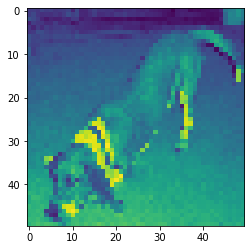